In [783]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib as plt
import pandas as pd

from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.datasets.utils import download_url


# Download e esplorazione dei dati

In [784]:
DATASET_URL = "https://gist.github.com/BirajCoder/5f068dfe759c1ea6bdfce9535acdb72d/raw/c84d84e3c80f93be67f6c069cbdc0195ec36acbd/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: ./insurance.csv


In [785]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [786]:
your_name = 'Renato'

In [787]:
def customize_dataset(dataframe_raw, rand_str):

    dataframe = dataframe_raw.copy(deep = True)         # Crea una copia del dataframe, ponendo deep = True le modifiche apportate non modifica il dataframe originale

    # Eliminazione di alcune righe
    dataframe = dataframe.sample(int(0.95 * len(dataframe)), random_state = int(ord(rand_str[0])))
    # .sample(): Restituisce un numero specificato di righe    /    random_state(): controlla il mescolamento dei dati prima di dividerli

    # Scalatura input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.

    # Scalatura target

    dataframe.charges = dataframe.charges * ord(rand_str[2])/100

    # Eliminazione colonne
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)

    return dataframe


In [788]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,charges
457,57,female,30.79995,0,no,13024.852555
1050,44,female,37.32455,1,no,8825.448995
56,58,female,32.14325,2,no,14968.105625
311,19,female,24.94700,0,no,1911.113600
1288,20,male,39.79400,2,yes,42179.022600


**Domanda 1:** quante righe ha **'dataset'**?

In [789]:
num_rows = len(dataframe.index)
num_rows

1271

**Domanda 2:** quante righe ha 'dataset'?

In [790]:
num_columns = len(dataframe.columns)
num_columns

6

**Domanda 3:** Quali sono i titoli delle colonne di input?

In [791]:
input_cols = dataframe.columns[:5].tolist()
input_cols

['age', 'sex', 'bmi', 'children', 'smoker']

**Domanda 4:** Quali colonne non possiedono valori numerici?

In [792]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_cols = dataframe.select_dtypes(exclude = numerics).columns.tolist()
categorical_cols

['sex', 'smoker']

**Domanda 5:** Quali sono i titoli delle colonne di output?

In [793]:
output_cols = dataframe.columns[5:6]
output_cols

Index(['charges'], dtype='object')

**Domanda bonus:** minimo, massimo e media dei valori in charges, si può vedere la distribuzione dei valori in un grafico?

In [794]:
max_charges = dataframe["charges"].max()
min_charges = dataframe["charges"].min()
mean_charges = dataframe["charges"].mean()

print('Il valore massimo è: ', max_charges)
print('Il valore minimo è: ', min_charges)
print('Il valore medio è: ', mean_charges)

Il valore massimo è:  70147.470811
Il valore minimo è:  1234.06129
Il valore medio è:  14433.083083868529


Distribuzione dei valori di charges:

<Axes: ylabel='Density'>

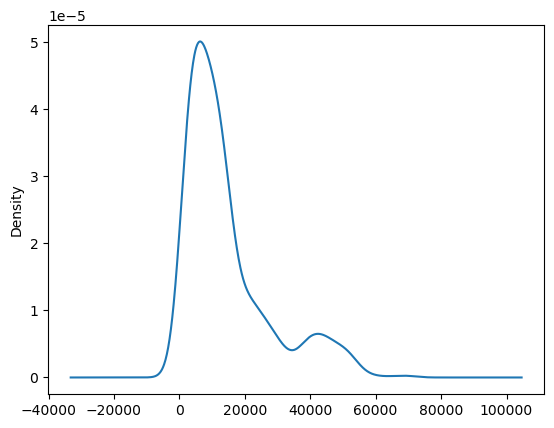

In [795]:
dataframe['charges'].plot(kind = 'kde')

# Preparazione dataset per il training

Per poter eserguire il training abbiamo bisogno di avere dei tensori, quindi faremo una trasformazione da pandas a pytorch: **Pandas --> NumPy --> Pytorch**

Passaggio da dataframe ad arry:

In [796]:
def dataframe_to_arrays(dataframe):
    dataframe1 = dataframe.copy(deep = True)        #copia dataframe

    # Conversione delle colonne non numeriche a numeriche
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes      # Categorizza attraverso codici numerici

    # Estrazione di input e output sotto forma di array numPy
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()

    return inputs_array, targets_array

In [797]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[57.     ,  0.     , 30.79995,  0.     ,  0.     ],
        [44.     ,  0.     , 37.32455,  1.     ,  0.     ],
        [58.     ,  0.     , 32.14325,  2.     ,  0.     ],
        ...,
        [59.     ,  0.     , 35.148  ,  2.     ,  0.     ],
        [41.     ,  1.     , 29.088  ,  1.     ,  0.     ],
        [36.     ,  0.     , 30.3202 ,  0.     ,  0.     ]]),
 array([[13024.852555],
        [ 8825.448995],
        [14968.105625],
        ...,
        [40601.668833],
        [ 6910.4585  ],
        [ 5799.39338 ]]))

**Domanda 6:** convertire array numpy in tensori PyTorch (NB! Fare attenzione che siano float32)

In [798]:
inputs = torch.from_numpy(inputs_array).to(torch.float32)
targets = torch.from_numpy(targets_array).to(torch.float32)

In [799]:
inputs.dtype, targets.dtype     # Verifica tipologia dati

(torch.float32, torch.float32)

In [800]:
dataset = TensorDataset(inputs, targets)
print(len(dataset))

1271


**Domanda 7:** Scegliere un numero tra 0.1 e 0.2 per determinare la frazione di dati che verranno usati per creare un validation set, quindi usare random_split per creare training e validation set

In [801]:
val_percent = 0.14
val_size = int (num_rows * val_percent)
print('Dimensione validation test: ', val_size)
train_size = num_rows - val_size
print('Dimensione training test: ', train_size)

train_ds, val_ds = random_split(dataset, [train_size, val_size])

Dimensione validation test:  177
Dimensione training test:  1094


**Domanda 8:** Scegliere una dimensione di lotto per il data loader

In [802]:
batch_size = 10

In [803]:
train_loader = DataLoader(train_ds, batch_size, shuffle = True)
val_loader = DataLoader(val_ds, batch_size)

In [804]:
for xb, yb in train_loader:
    print('inputs: ', xb)
    print('targets: ', yb)
    break

inputs:  tensor([[26.0000,  1.0000, 31.3757,  0.0000,  0.0000],
        [45.0000,  1.0000, 23.1239,  0.0000,  1.0000],
        [30.0000,  1.0000, 31.7140,  1.0000,  0.0000],
        [22.0000,  1.0000, 37.9962,  1.0000,  1.0000],
        [52.0000,  1.0000, 27.6336,  0.0000,  1.0000],
        [51.0000,  0.0000, 34.2542,  0.0000,  0.0000],
        [18.0000,  1.0000, 53.6613,  0.0000,  0.0000],
        [61.0000,  0.0000, 31.4716,  0.0000,  0.0000],
        [40.0000,  1.0000, 41.6423,  1.0000,  0.0000],
        [23.0000,  1.0000, 26.7751,  0.0000,  0.0000]])
targets:  tensor([[ 2969.5251],
        [38576.3125],
        [ 4025.2805],
        [40881.6797],
        [26832.9844],
        [10852.9355],
        [ 1279.8090],
        [14771.9385],
        [ 7271.1206],
        [ 1997.4635]])


# Creare un modello di regressione lineare

In [805]:
input_size = len(input_cols)
output_size = len(output_cols)

In [806]:
input_size

5

In [807]:
output_size

1

In [808]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.cross_entropy(out,targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.cross_entropy(out,targets)  
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))  

In [809]:
model = InsuranceModel()

In [810]:
model.linear.weight

Parameter containing:
tensor([[-0.1097,  0.3521, -0.3389, -0.4014,  0.3951]], requires_grad=True)

In [811]:
model.linear.bias

Parameter containing:
tensor([0.3373], requires_grad=True)

In [812]:
print(next(iter(val_loader)))

[tensor([[26.0000,  1.0000, 21.0080,  0.0000,  0.0000],
        [18.0000,  1.0000, 33.8703,  0.0000,  1.0000],
        [41.0000,  1.0000, 28.6891,  1.0000,  0.0000],
        [27.0000,  0.0000, 35.1480,  1.0000,  0.0000],
        [18.0000,  1.0000, 39.5314,  0.0000,  0.0000],
        [58.0000,  1.0000, 37.3246,  2.0000,  1.0000],
        [27.0000,  1.0000, 32.9109,  3.0000,  0.0000],
        [57.0000,  1.0000, 40.7737,  0.0000,  0.0000],
        [58.0000,  0.0000, 29.2900,  0.0000,  0.0000],
        [44.0000,  0.0000, 37.3246,  1.0000,  0.0000]]), tensor([[ 2532.5300],
        [38079.6250],
        [ 7331.1548],
        [ 3935.7988],
        [14179.0635],
        [52246.1445],
        [ 5331.6123],
        [12080.7510],
        [13026.6865],
        [ 8825.4492]])]


# Training del modello

In [813]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Domanda 9:** usa la funzione evaluate per calcolare la perdita del validation set prima del training

In [814]:
result = evaluate(model, val_loader)
print(result)

{'val_loss': 0.0}
